In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
from datainterface.loadpatient import LoadPat

sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import tvbsim.util

import processing
import processing.preprocessfft
from processing.util import DataHandler
import peakdetect

import os
import numpy as np
import scipy
import scipy.io 
import pandas as pd
import time

from natsort import natsorted
import ntpath
from sklearn.decomposition import PCA
from processing.dsp.frequencyanalysis import MultiTaperFFT

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from shutil import copyfile

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [2]:
# get all datafiles for the fft maps
fftdatadir = '/Volumes/ADAM LI/pydata/output/outputfft/tng/'
# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(fftdatadir):
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))
print(len(datafiles))
# print(datafiles[7:])

22


In [3]:
rawdatadir = '/Volumes/ADAM LI/pydata/convertedtng/'
checkrawdata = lambda patient: os.path.join(rawdatadir, patient)

expname = 'realtng'
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata_fft/', 
                        expname)
if not os.path.exists(trainimagedir):
    os.makedirs(traindir)
print(trainimagedir)

################# META DATA FOR LOCATIONS ############################
metadatadir = lambda patient: os.path.join('/Volumes/ADAM LI/pydata/metadata/', patient)  
# get the important files

def renamefiles(project_dir):
    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    
    try:
#         copyfile(sensorsfile, newsensorsfile)
        os.rename(sensorsfile, newsensorsfile)
    except:
        print("Already renamed seeg.xyz possibly!")

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
#         copyfile(gainmatfile, newgainmatfile)
        os.rename(gainmatfile, newgainmatfile)
    except:
        print("Already renamed gain_inv-square.mat possibly!")


/Volumes/ADAM LI/pydata/dnn/traindata_fft/realtng


In [4]:
# establish frequency bands
freqbands = {
        'dalpha':[0,15],
        'beta':[15,30],
        'gamma':[30,90],
        'high':[90,200],
    }
postprocessfft = processing.preprocessfft.PreProcess(freqbands=freqbands)

winsizems = 500
stepsizems = 250
typetransform = 'fourier'
mtbandwidth = 4
mtfreqs = []

In [9]:
# load in the onset/offset times
dataloader = LoadPat(patient='id001_ac_sz2', datadir=rawdatadir)
rawdata = dataloader.loadrawdata_fromfile()
samplerate = dataloader.samplerate

mtaperfft = MultiTaperFFT(winsizems, stepsizems, samplerate, 
                          mtbandwidth, typetransform)
print(rawdata.shape)
print(mtaperfft.winsamps/samplerate)
print(len(mtaperfft.freqsfft))

mtaperfft.loadrawdata(rawdata)
# eegwin = rawdata[:,0:int(mtaperfft.winsamps)]
# print(eegwin.shape)
# print(mtaperfft.winsamps)
test =mtaperfft.mtwelch()
# test = np.fft.fft(eegwin)
# testwin = np.fft.fftfreq(eegwin)
print(test.shape)

Loaded  id001_ac_sz2
Loaded channels file data
value error in birth date probably, so just setting to nan
Ran setup of annotations data!
Loaded raw data
(84, 383488)
0.5
129


In [92]:
AZIM = 0
# define the data handler 
datahandler = DataHandler()
pca = PCA(n_components=2)

for idx, datafile in enumerate(datafiles):
    print(idx)
    # perform file identification
    dirname = os.path.dirname(datafile)
    filename = path_leaf(datafile)
    fileid = filename.split('_fftmodel')[0]
    patient = '_'.join(fileid.split('_')[0:2])
    
    # check that I didn't append something to dir to move it
    if not os.path.exists(checkrawdata(fileid)):
        continue
    
    fftdata = np.load(datafile)
    power = fftdata['power']
    freqs = fftdata['freqs']
    timepoints = fftdata['timepoints']
    rawchans = fftdata['chanlabels']
    
    # get metadata for this patient, specifically the SEEG locations
    renamefiles(metadatadir(patient))
    seegfile = os.path.join(metadatadir(patient), 'seeg.txt')
    seeg_pd = pd.read_csv(seegfile, names=['x','y','z'], delim_whitespace=True)
    seeg_labels = seeg_pd.index.values
    seeg_xyz = seeg_pd.as_matrix(columns=None)
    
    # load in the onset/offset times
    dataloader = LoadPat(patient=fileid, datadir=rawdatadir)
    onset_times = dataloader.onset_time
    offset_times = dataloader.offset_time
#     print(dataloader.onset_time)
#     print(dataloader.offset_time)
    print("Patient is: ", patient)
    print("file id is: ", fileid)
#     print(dirname)
#     print("Filename loaded is: ", filename)
    print("\n\n")
    
    # get indices of channels that we have seeg_xyz for
    chanindices = [i for i,x in enumerate(rawchans) if any(thing == x for thing in seeg_labels)]
    chanlabels = rawchans[chanindices]
    power = np.abs(power[chanindices,:,:])
    
    # get overlapping indices on seeg with xyz
    xyzinds = [i for i,x in enumerate(seeg_labels) if any(thing==x for thing in chanlabels)]
    seeg_xyz = seeg_xyz[xyzinds,:]
    
    print(chanlabels.shape)
    print(len(chanindices))
    print(power.shape)
    assert power.shape[0] == seeg_xyz.shape[0]
    assert power.shape[0] == len(chanlabels)
    
    # postprocess fft into bins
    power = postprocessfft.binFrequencyValues(power, freqs)

    # project xyz data
    if AZIM==1:
        print("using azim projection to grid image")
    if AZIM==0:
        print("using pca to grid image")
        seeg_xyz = pca.fit_transform(seeg_xyz)
    
    print(seeg_xyz.shape)
    print(power.shape)
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(seeg_xyz, power, 
                            n_gridpoints=32, normalize=False, augment=False, 
                            pca=False, std_mult=0., edgeless=False)
    
    # compute ylabels    
    ylabels = datahandler.computelabels(onset_times, offset_times, timepoints)
    # instantiate metadata hash table
    metadata = dict()
    metadata['chanlabels'] = chanlabels
    metadata['seeg_xyz'] = seeg_xyz
    metadata['ylabels'] = ylabels
    metadata['samplerate'] = samplerate
    metadata['timepoints'] = timepoints
    
    # save image and meta data
    imagefilename = os.path.join(trainimagedir, filename.split('.npz')[0])
    print(image_tensor.shape)
    print('saved at ', imagefilename)
    np.savez_compressed(imagefilename, image_tensor=image_tensor, metadata=metadata)

0
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Loaded  id001_ac_absence
Loaded channels file data
value error in birth date probably, so just setting to nan
Ran setup of annotations data!
Patient is:  id001_ac
file id is:  id001_ac_absence



(70,)
70
(70, 129, 1799)
using pca to grid image
(70, 2)
(70, 4, 1799)
(1799, 70)
(1799, 4, 32, 32)9/1799terpolating 33/1799Interpolating 79/1799Interpolating 126/1799Interpolating 174/1799Interpolating 217/1799Interpolating 265/1799Interpolating 311/1799Interpolating 359/1799Interpolating 406/1799Interpolating 449/1799Interpolating 489/1799Interpolating 531/1799Interpolating 575/1799Interpolating 622/1799Interpolating 668/1799Interpolating 715/1799Interpolating 762/1799Interpolating 810/1799Interpolating 858/1799Interpolating 906/1799Interpolating 953/1799Interpolating 998/1799Interpolating 1041/1799Interpolating 1088/1799Interpolating 1134/1799Interpolating 1181/1799Interpolating 1217/1799Interpolating 1310/17

Interpolating 7071/7071terpolating 35/7071Interpolating 70/7071Interpolating 107/7071Interpolating 144/7071Interpolating 181/7071Interpolating 218/7071Interpolating 254/7071Interpolating 291/7071Interpolating 328/7071Interpolating 365/7071Interpolating 401/7071Interpolating 438/7071Interpolating 475/7071Interpolating 511/7071Interpolating 547/7071Interpolating 583/7071Interpolating 619/7071Interpolating 654/7071Interpolating 691/7071Interpolating 728/7071Interpolating 765/7071Interpolating 801/7071Interpolating 838/7071Interpolating 876/7071Interpolating 914/7071Interpolating 950/7071Interpolating 983/7071Interpolating 1018/7071Interpolating 1055/7071Interpolating 1092/7071Interpolating 1128/7071Interpolating 1164/7071Interpolating 1201/7071Interpolating 1237/7071Interpolating 1273/7071Interpolating 1310/7071Interpolating 1347/7071Interpolating 1383/7071Interpolating 1419/7071Interpolating 1454/7071Interpolating 1486/7071Interpolating 1523/7071Interpolating 1559/7071Interpolating 1596/

Interpolating 10262/14387erpolating 35/14387Interpolating 74/14387Interpolating 111/14387Interpolating 144/14387Interpolating 176/14387Interpolating 206/14387Interpolating 238/14387Interpolating 269/14387Interpolating 301/14387Interpolating 339/14387Interpolating 378/14387Interpolating 413/14387Interpolating 450/14387Interpolating 490/14387Interpolating 521/14387Interpolating 554/14387Interpolating 593/14387Interpolating 625/14387Interpolating 660/14387Interpolating 698/14387Interpolating 734/14387Interpolating 773/14387Interpolating 804/14387Interpolating 842/14387Interpolating 872/14387Interpolating 903/14387Interpolating 935/14387Interpolating 965/14387Interpolating 996/14387Interpolating 1029/14387Interpolating 1067/14387Interpolating 1105/14387Interpolating 1135/14387Interpolating 1173/14387Interpolating 1206/14387Interpolating 1238/14387Interpolating 1276/14387Interpolating 1314/14387Interpolating 1348/14387Interpolating 1385/14387Interpolating 1425/14387Interpolating 1465/14387I

Interpolating 14386/14387Interpolating 10293/14387Interpolating 10307/14387Interpolating 10320/14387Interpolating 10330/14387Interpolating 10344/14387Interpolating 10359/14387Interpolating 10374/14387Interpolating 10388/14387Interpolating 10401/14387Interpolating 10430/14387Interpolating 10444/14387Interpolating 10462/14387Interpolating 10496/14387Interpolating 10510/14387Interpolating 10527/14387Interpolating 10546/14387Interpolating 10561/14387Interpolating 10592/14387Interpolating 10608/14387Interpolating 10623/14387Interpolating 10638/14387Interpolating 10653/14387Interpolating 10699/14387Interpolating 10711/14387Interpolating 10725/14387Interpolating 10738/14387Interpolating 10754/14387Interpolating 10776/14387Interpolating 10791/14387Interpolating 10806/14387Interpolating 10826/14387Interpolating 10839/14387Interpolating 10855/14387Interpolating 10872/14387Interpolating 10888/14387Interpolating 10905/14387Interpolating 10926/14387Interpolating 10938/14387Interpolating 10954/14387

# Append Sample Rate and Time Points To Data

In [11]:
for idx, datafile in enumerate(datafiles):
    print(idx)
    # perform file identification
    dirname = os.path.dirname(datafile)
    filename = path_leaf(datafile)
    fileid = filename.split('_fftmodel')[0]
    patient = '_'.join(fileid.split('_')[0:2])
    
    fftdata = np.load(datafile)
    timepoints = fftdata['timepoints']
    
    # check that I didn't append something to dir to move it
    if not os.path.exists(checkrawdata(fileid)):
        continue
        
    # load in the onset/offset times
    dataloader = LoadPat(patient=fileid, datadir=rawdatadir)
    samplerate = dataloader.samplerate

    imagedata = np.load(os.path.join(trainimagedir, filename))
    image_tensor = imagedata['image_tensor']
    metadata = imagedata['metadata'].item()
    metadata['samplerate'] = samplerate
    metadata['timepoints'] = timepoints
    
    print('saved at ', os.path.join(trainimagedir, filename))
    np.savez_compressed(os.path.join(trainimagedir, filename), image_tensor=image_tensor, metadata=metadata)
    print(metadata.keys())

0
Loaded  id001_ac_absence
Loaded channels file data
value error in birth date probably, so just setting to nan
Ran setup of annotations data!
saved at  /Volumes/ADAM LI/pydata/dnn/traindata_fft/realtng/id001_ac_absence_fftmodel.npz
dict_keys(['chanlabels', 'seeg_xyz', 'ylabels', 'samplerate', 'timepoints'])
1
Loaded  id001_ac_comp
Loaded channels file data
value error in birth date probably, so just setting to nan
Ran setup of annotations data!
saved at  /Volumes/ADAM LI/pydata/dnn/traindata_fft/realtng/id001_ac_comp_fftmodel.npz
dict_keys(['chanlabels', 'seeg_xyz', 'ylabels', 'samplerate', 'timepoints'])
2
Loaded  id001_ac_sz2
Loaded channels file data
value error in birth date probably, so just setting to nan
Ran setup of annotations data!
saved at  /Volumes/ADAM LI/pydata/dnn/traindata_fft/realtng/id001_ac_sz2_fftmodel.npz
dict_keys(['chanlabels', 'seeg_xyz', 'ylabels', 'samplerate', 'timepoints'])
3
Loaded  id001_ac_sz2_2
Loaded channels file data
value error in birth date probabl

# Concatenate Files Into One File

In [12]:
for idx, datafile in enumerate(datafiles):
    print(idx)
    # perform file identification
    dirname = os.path.dirname(datafile)
    filename = path_leaf(datafile)
    fileid = filename.split('_fftmodel')[0]
    patient = '_'.join(fileid.split('_')[0:2])
    
    # check that I didn't append something to dir to move it
    if not os.path.exists(checkrawdata(fileid)):
        continue
        
    imagedata = np.load(os.path.join(trainimagedir, filename))
    image_tensor = imagedata['image_tensor']
    metadata = imagedata['metadata'].item()
    
    if idx == 0:
        image_tensors = image_tensor
        ylabels = metadata['ylabels']
    else:
        image_tensors = np.append(image_tensors, image_tensor, axis=0)
        ylabels = np.append(ylabels, metadata['ylabels'], axis=0)
    
#     print(image_tensor.shape)
#     print(imagedata.keys())
#     print(metadata.keys())
#     break
#     print('saved at ', os.path.join(trainimagedir, filename))
#     np.savez_compressed(os.path.join(trainimagedir, filename), image_tensor=image_tensor, metadata=metadata)
#     print(metadata.keys())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [13]:
print(image_tensors.shape)
print(ylabels.shape)

np.savez_compressed(os.path.join(trainimagedir, 'allimages.npz'),
                   image_tensor=image_tensors, ylabels=ylabels)

(47247, 4, 32, 32)
(47247, 1)


In [41]:
data = np.load(os.path.join(trainimagedir, 'allimages.npz'))
images = data['image_tensor']
ylabels = data['ylabels']
print(images.shape)
print(ylabels.shape)

print(np.sum(ylabels))
print((ylabels.size - np.sum(ylabels)))

(47247, 4, 32, 32)
(47247, 1)
13113.0
34134.0


In [42]:
print("to predict 1: ", np.sum(ylabels)/ylabels.size)
print("to predict 0: ", (ylabels.size - np.sum(ylabels))/ylabels.size)

print(((ylabels.size - np.sum(ylabels))/ylabels.size)/ (np.sum(ylabels)/ylabels.size))

to predict 1:  0.2775414312019811
to predict 0:  0.722458568798019
2.603065660032029


In [38]:
from sklearn.utils import class_weight
# invert_y = 1 - ylabels
# ylabels = np.concatenate((invert_y, ylabels),axis=1)
print(ylabels)
print(np.argmax(ylabels, axis=1))
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ylabels).astype(int),
                                                 np.argmax(ylabels, axis=1))


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[0 0 0 ... 0 0 0]


In [40]:
print(class_weight)
# print(ylabels.shape)
print(np.unique(ylabels))


[0.69208121 1.80153283]
[0. 1.]


# Get Data Distribution For Sequence Length Before and After Seizure

- get preictal length
- get postictal length
- get length of seizure

In [30]:
preinds = []
pretimes = []
postinds = []
posttimes = []
allinds = []
alltimes = []
for idx, datafile in enumerate(datafiles):
    print(idx)
    # perform file identification
    dirname = os.path.dirname(datafile)
    filename = path_leaf(datafile)
    fileid = filename.split('_fftmodel')[0]
    patient = '_'.join(fileid.split('_')[0:2])
    
    # check that I didn't append something to dir to move it
    if not os.path.exists(checkrawdata(fileid)):
        continue
        
    imagedata = np.load(os.path.join(trainimagedir, filename))
    metadata = imagedata['metadata'].item()
    ylabels = metadata['ylabels']
    timepoints = metadata['timepoints']
    
    # total indices and time of dataset
    totalind = len(ylabels)
    totaltime = timepoints[-1,0]
    
    # get the index when ylabels is first onset
    onsetind = np.where(ylabels == 1)[0][0]
    onsettime = timepoints[onsetind,0]
    
#     print(timepoints[onsetind,:])
    # get index of offset if it exists
    try:
        offsetind = np.where(ylabels[onsetind+5:] == 0)[0][0]
        offsettime = timepoints[offsetind,0]
        
        posttime = totaltime - offsettime
        postind = totalind - offsetind
    except IndexError:
        print("here")
        offsetind = None
        offsettime = None
        posttime = -10
        postind = -10
    
    alltimes.append(totaltime)
    allinds.append(totalind)
    preinds.append(onsetind)
    pretimes.append(onsettime)
    postinds.append(postind)
    posttimes.append(posttime)
#     print(onsetind, onsettime)
#     print(postind, posttime)
    
#     print(image_tensor.shape)
#     print(imagedata.keys())
#     print(metadata.keys())
#     break
#     print('saved at ', os.path.join(trainimagedir, filename))
#     np.savez_compressed(os.path.join(trainimagedir, filename), image_tensor=image_tensor, metadata=metadata)
#     print(metadata.keys())

0
1
2
3
4
here
5
6
7
here
8
here
9
10
11
12
13
14
15
16
17
18
19
20
21


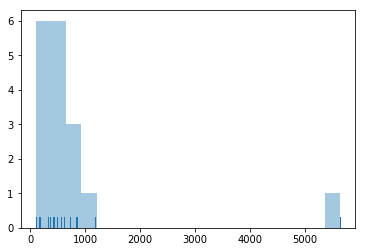

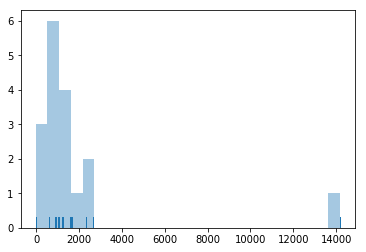

In [32]:
fig = plt.figure()
sns.distplot(preinds, rug=True, kde=False)

fig = plt.figure()
sns.distplot(postinds,rug=True,  kde=False)


298500.0


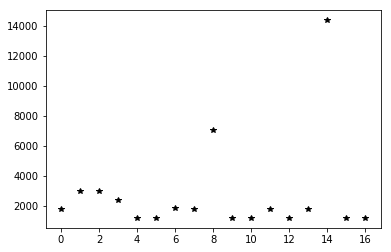

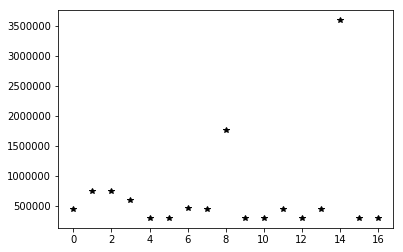

In [34]:
print(min(alltimes))
fig = plt.figure()
plt.plot(allinds, 'k*')

fig = plt.figure()
plt.plot(alltimes, 'k*')

### Discussion on LSTM Data Sequence formation

We will want to split each dataset into possibly a sequence of 5x-6x our lstm length, so for a lstm that analyzes a window of 5 seconds, we want 25-30 seconds of data sequence. We can use np.arraysplitter to split the data by time.

Then we want to pad both the beginning and end by 0 images with 5 seconds (if we want to do bidirectional, need to pad end as well). 

This will produce many many sequences that we want to produce an output for each window in the lstm cells.

# Visualize FFT Maps In 3D

In [97]:
print(seeg_labels.shape)
print(power.shape)
onset_times = dataloader.onset_time
offset_times = dataloader.offset_time
    
onset_index = np.where(ylabels==1)[0][0]
offset_index = np.where(ylabels[onset_index+5:] == 0)[0][0]
    
print(onset_times, offset_times)
print(timepoints[])

(70,)
(70, 129, 1799)
88889.9999744 145401.9999744


In [112]:
import matplotlib
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    
    # initialize figure to draw on
    fig, ax = plt.subplots(figsize=(8,6))
    ax.volume = volume
    
    # set index as the first axis
    ax.index = volume.shape[0] // 2
    
    # plot the 3D volume heat map
#     ax.plot = sns.heatmap(volume[ax.index], cmap='jet',
#                yticklabels=freqs)
#     ax.invert_yaxis()
    ax.imshow(volume[ax.index], cmap='jet',aspect='auto')
    ax.set_yticks(np.arange(0.5,volume.shape[1]-0.5, 5))
    ax.set_yticklabels(np.flipud(freqs[0::5]))
    ax.axvline(onset_index, color='black', linestyle='dashed', linewidth=5)
    ax.axvline(offset_index, color='black', linestyle='dashed', linewidth=5)
    # Hide grid lines
    ax.grid(False)
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j': # go to previous slice
        previous_slice(ax)
    elif event.key == 'k': # go to next slice
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    '''
    a helper function to remove keys that we want 
    to use wherever they may appear in this dictionary.
    '''
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
    

<IPython.core.display.Javascript object>


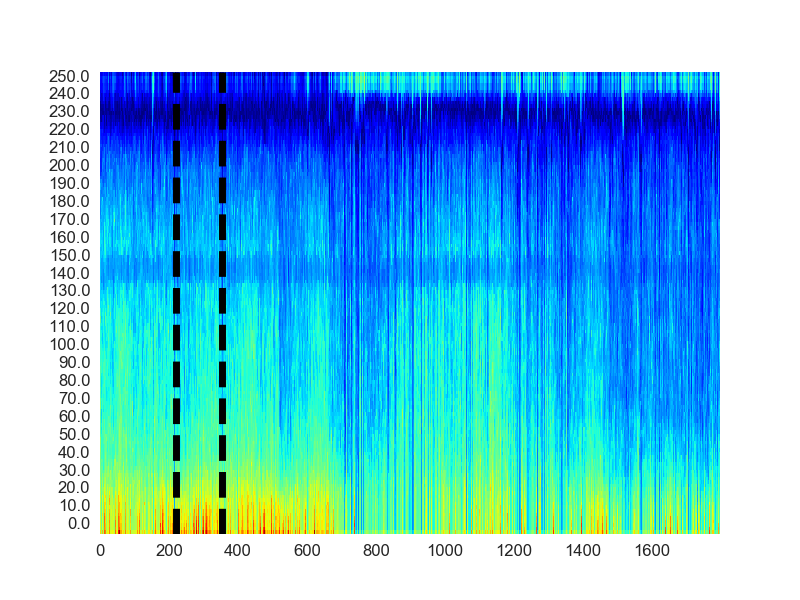

In [113]:
# fig, ax = plt.subplots()
# ax.imshow(image_tensor[0,0,:,:,:])
# fig.canvas.mpl_connect('key_press_event', process_key)
%matplotlib notebook
sns.set(font_scale=1.2)
multi_slice_viewer(np.abs(power[:,:,:]))